In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from unidecode import unidecode

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read ERA as GRIB files

The [ERA5-Land monthly averaged Reanalysis-data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) has been manually downloaded from the copernicus climate change service.

In [2]:
# tmean and LAI 1968-2023
df1 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgid'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 1968 - 2001
df2 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgas'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 2002-2023
df3 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgad'}).to_dataframe().reset_index().dropna().reset_index(drop=True)

rain = pd.concat([df2, df3], ignore_index=True).dropna().reset_index(drop=True)
era = df1.merge(rain, on=["time", "latitude", "longitude", "number", "step", "surface", "valid_time"])

Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file


### 2. Preprocess ERA

In [3]:
# Kelvin to Celsius
era["t2m"] = era["t2m"].apply(lambda x: x - 273.15)
# time to datetime
era["time"] = pd.to_datetime(era["time"])
era["valid_time"] = pd.to_datetime(era["valid_time"])

era = (era
       .sort_values(by=["time", "latitude", "longitude"])
       .loc[:, ["time", "latitude", "longitude", "t2m", "tp"]]
       .rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tp":"rain"})
       .reset_index(drop=True))

era["lat"] = era["lat"].round(1)
era["lon"] = era["lon"].round(1)
era["month"] = era["time"].dt.month
era["year"] = era["time"].dt.year
era = era.loc[era["month"].between(9,11) & (era["year"].between(1993,2016))].reset_index(drop=True)
era = era[["time", "lat", "lon", "rain", "tmean", "month", "year"]]
era = gpd.GeoDataFrame(era, geometry=gpd.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))

era.head(2)

,time,lat,lon,rain,tmean,month,year,geometry
0,1993-09-01,-42.0,-69.0,0.000550,3.03335,9,1993,POINT (-69.00000 -42.00000)
1,1993-09-01,-42.0,-68.9,0.000521,2.65835,9,1993,POINT (-68.90000 -42.00000)


### 3. Read SCM

<Axes: >

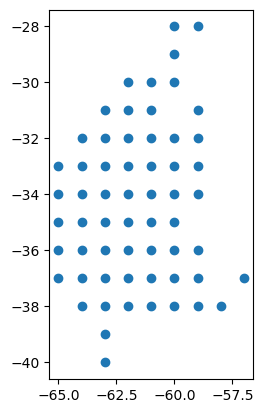

In [4]:
# Read and preprocess hindcast data from different climate models
c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
#apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")
scm = pd.concat([nmme, c3s], ignore_index=True).drop_duplicates()
scm = scm.rename(columns={"forecasted_month":"month"})
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(6, 11) & (scm["model"].isin(['GFDL', 'CCSM4', 'NASA', 'CMCC', 'DWD', 'ECMWF', 'METFR', 'UKMO', 'ECCC'])))].reset_index(drop=True)

scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"], crs="EPSG:4326"))

study_region = gpd.read_file("files/shapefiles/study_region.shp")
# directly spatial join takes too much time
coordinates = gpd.sjoin(scm[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
scm = scm.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

scm[["lat", "lon", "geometry"]].drop_duplicates().plot()

### 4. Filter ERA

In [6]:
era["lat_bin"] = pd.cut(era["lat"], np.arange(-41.5, -26.5, 1), labels=np.arange(-41, -27, 1))
era["lon_bin"] = pd.cut(era["lon"], np.arange(-65.5, -55.5, 1), labels=np.arange(-65, -56, 1))

era_filtered = era.dropna().groupby(["lat_bin", "lon_bin", "year", "month"])[["rain", "tmean"]].mean().reset_index()
era_filtered = era_filtered.rename(columns={"lat_bin":"lat", "lon_bin":"lon"})
era_filtered = gpd.GeoDataFrame(era_filtered, geometry=gpd.points_from_xy(era_filtered["lon"], era_filtered["lat"], crs="EPSG:4326"))

coordinates = gpd.sjoin(era[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
era = era.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

coordinates = gpd.sjoin(era_filtered[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
era_filtered = era_filtered.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

era_filtered.head()

,lat,lon,year,month,rain,tmean,geometry
0,-40,-63,1993,9,0.000671,11.306104,POINT (-63.00000 -40.00000)
1,-40,-63,1993,10,0.001130,15.560000,POINT (-63.00000 -40.00000)
2,-40,-63,1993,11,0.001814,17.768086,POINT (-63.00000 -40.00000)
3,-40,-63,1994,9,0.000847,12.451104,POINT (-63.00000 -40.00000)
4,-40,-63,1994,10,0.001016,14.237861,POINT (-63.00000 -40.00000)


### Visualize

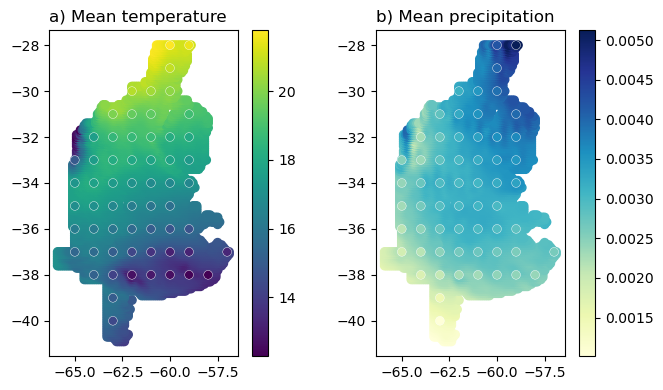

In [28]:
era_plot = era.dissolve(
                by=["lat", "lon"],
                aggfunc={
                    "rain": "mean",
                    "tmean": "mean",
                }
            ).reset_index()

era_plot_grid = era_filtered.dissolve(
                        by=["lat", "lon"],
                        aggfunc={
                            "rain": "mean",
                            "tmean": "mean",
                        }
                    ).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(7,4))
axs = axs.ravel()

era_plot.plot(column="tmean", ax=axs[0], legend=True)
era_plot_grid.plot(column="tmean", ax=axs[0], markersize=40, edgecolor="white", linewidth=.3, legend=False)
axs[0].set_title("a) Mean temperature", loc="left");
era_plot.plot(column="rain", ax=axs[1], legend=True, cmap="YlGnBu")
era_plot_grid.plot(column="rain", ax=axs[1], markersize=40, edgecolor="white", linewidth=.3, cmap="YlGnBu", legend=False)
axs[1].set_title("b) Mean precipitation", loc="left");

plt.tight_layout()
plt.show()

In [ ]:
era_filtered[["lat", "lon"]].drop_duplicates().shape

(60, 2)

### 2.5 Restructure dataset

In [ ]:
era_features = era_filtered.pivot(index="year", columns=["lat", "lon", "month"], values=["rain", "tmean"])
era_features.columns = ["{}_{}_{}_{}".format(s[0],s[1],s[2],s[3]) for s in era_features.columns]
era_features = era_features.reset_index()
era_features.head()

,year,rain_-40_-63_9,rain_-40_-63_10,rain_-40_-63_11,rain_-39_-63_9,rain_-39_-63_10,rain_-39_-63_11,rain_-38_-64_9,rain_-38_-64_10,rain_-38_-64_11,...,tmean_-30_-60_11,tmean_-29_-60_9,tmean_-29_-60_10,tmean_-29_-60_11,tmean_-28_-60_9,tmean_-28_-60_10,tmean_-28_-60_11,tmean_-28_-59_9,tmean_-28_-59_10,tmean_-28_-59_11
0,1993,0.000671,0.001130,0.001814,0.000716,0.002023,0.002440,0.000882,0.002075,0.003498,...,21.296621,16.584326,20.568613,21.658359,17.307646,21.267793,22.227148,17.075576,21.498145,22.421328
1,1994,0.000847,0.001016,0.000386,0.001142,0.001290,0.001002,0.001012,0.001777,0.001573,...,21.830527,19.365068,20.438232,22.027578,20.371104,21.251240,22.437793,20.089111,21.267920,22.614141
2,1995,0.000159,0.001355,0.001183,0.000216,0.001739,0.002208,0.000158,0.001476,0.002924,...,24.081221,18.384072,19.746191,25.411514,19.093174,20.283477,26.025752,18.963564,20.000977,25.744502
3,1996,0.000431,0.002184,0.000928,0.000796,0.002241,0.001937,0.000933,0.002020,0.002035,...,23.235049,17.549082,20.636279,23.252744,18.176309,20.804053,23.367686,17.754316,20.653174,23.578154
4,1997,0.001579,0.002229,0.001993,0.001580,0.002381,0.001929,0.001900,0.002539,0.001686,...,22.754453,19.165195,20.688779,23.076641,20.575977,21.351982,23.679609,20.097109,21.077139,23.816895


In [ ]:
era_features.to_csv("files/ERA/processed/era_tmean_rain_all_departments.csv", index=False)

### 2.6 Basis Expansion

In [ ]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for year in list(range(1993, 2017)):
        # split
        features_used_for_standardization = data.loc[data["year"] != year, [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        features_to_standardize = data.loc[(data["year"] == year), [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        # standardize
        features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
        # bring it together
        year = data.loc[(data["year"] == year), ["year"]].reset_index(drop=True)
        standardized_df = pd.concat([year, features_standardized], axis=1)
        standardized_data.append(standardized_df)
    df_standardized = pd.concat(standardized_data, ignore_index=True)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    
    # store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    y = df_standardized.loc[:, ["year"]].reset_index(drop=True)
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)

    # standardize expanded features again
    df_standardized = standardize_loyo(data_expanded)
    
    return df_standardized

In [ ]:
era_basis_expansion = apply_basis_expansion(era_features)
era_basis_expansion.head(2)

,year,tmeansquared_-40_-63_9,tmeansquared_-40_-63_10,tmeansquared_-40_-63_11,tmeansquared_-39_-63_9,tmeansquared_-39_-63_10,tmeansquared_-39_-63_11,tmeansquared_-38_-64_9,tmeansquared_-38_-64_10,tmeansquared_-38_-64_11,...,tmeanrain_-30_-60_11,tmeanrain_-29_-60_9,tmeanrain_-29_-60_10,tmeanrain_-29_-60_11,tmeanrain_-28_-60_9,tmeanrain_-28_-60_10,tmeanrain_-28_-60_11,tmeanrain_-28_-59_9,tmeanrain_-28_-59_10,tmeanrain_-28_-59_11
0,1993,-0.804068,-0.551056,-0.170074,-0.954209,-0.487716,0.273058,-0.939407,-0.438069,0.613410,...,-0.536544,-0.909878,-0.670691,-0.412663,0.28843,-0.357500,-0.707764,-0.046632,-0.133073,-1.036243
1,1994,-0.499194,-0.232915,0.068395,-0.662785,-0.244537,0.180761,-0.757140,-0.254513,0.150463,...,0.132331,0.673351,-0.155326,-0.140211,0.01030,0.212708,-0.246367,0.402256,-0.079192,-0.271787


### 2.7 EXPORT

In [ ]:
era_basis_expansion.to_csv("files/ERA/processed/era_basis_expansion_all_departments.csv", index=False)